In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Excercise 1. Backpropagation
Add Backpropagation to your MLP and train the model on the ZIP-Dataset.

In [13]:
class MLP:
    def __init__(self, depth, layer_width, gamma=0.01, iterations=1000, no_batches=100):
        """
        This constructor sets random network weights and checks if the input depth matches the provided layers.
        depth -- the network depth, needs to be >= 2 and equal to len(layer_width) - 1
        layer_width -- an integer array of layer widths, including the input layer width
        gamma -- the learning rate for changing the gradient in backpropagation
        iterations -- the number of backprop iterations to perform
        no_batches -- the number of stochastic gradient descent batches to take per iteration
        """
        self.gamma = gamma # learning rate
        self.iterations = iterations
        self.no_batches = no_batches
        if depth < 2:
            raise Exception("Depth needs to be at least 2 (one hidden and one output layer)!!")  
        self.depth = depth
        if not len(layer_width) == (depth + 1):
            raise Exception("'layer_width' needs to be of length 'depth' + 1")  
        self.layer_width = layer_width
        self.network_weights = []
        #self.network_biases = []
        width_prev = self.layer_width[0]
        for width in self.layer_width[1:]:
            #added +1 to incorporate bias into weight
            self.network_weights.append(np.random.randn(width_prev+1, width)* np.sqrt(1. / width_prev+1))
            #self.network_biases.append(np.zeros((1, width)))
            width_prev = width
        self.error_memory = []
    
    def heaviside(self, Z):
        """
        This Function is a tiny implementation of the heaviside step function. 
        Not used, due to to the derivative being useless for backpropagation.
        """
        return (Z > 0).astype(int)
    
    def heaviside_derivative(self, Z):
        """
        This Function returns the evaluated derivative of the heaviside step function.
        Not used, due to to this derivative being useless for backpropagation.
        """
        return np.where(Z == 0, 0, np.inf)
    
    def sigmoid(self, Z):
        """The activation function used instead of the Heaviside step function. Z is the output of weights * X_i."""
        return 1./(1.+np.exp(-Z))
    
    def sigmoid_derivative(self, Z):
        """The derivative of the sigmoid activation function, used in backpropagation. Z is the output of weights * X_i."""
        return self.sigmoid(Z) * (1-self.sigmoid(Z))
    
    def error_function(self, y_i, t_i):
        """The error function used, where y_i are the predicted, and t_i the true labels."""
        return 0.5 * np.power(y_i - t_i, 2)
    
    def error_function_derivative(self, y_i, t_i):
        """The derivative of the error function, that is used in backprop, where y_i are the predicted, and t_i the true labels."""
        return y_i - t_i
    
    def forward_pass(self, X, f_activation, deriv_activation):
        """
        This Function passes the input X through all weights and returns the prediction vector.
        The activation function and it's derivative are passed as parameters.
        The means of the evaluated derivatives of the batch are stored for the backward pass.
        """
        self.activated_X_i = []
        self.derivated_X_i = []
        X_i = X.copy()
        for i in range(self.depth):
            X_i = np.hstack((X_i, np.ones((X_i.shape[0],1))))
            z_i = X_i @ self.network_weights[i]
            X_i = f_activation(z_i)
            deriv_X_i = deriv_activation(z_i)
            self.activated_X_i.append(X_i)
            self.derivated_X_i.append(np.diag(np.mean(deriv_X_i, axis=0)))
        return X_i
    
    def backward_pass_updates(self, X, deriv_error):
        """
        This Function passes backwards through the network for backpropagation.
        The network weights are updated by the learning rate scaled derivatives, calculated in the forward pass.
        """
        delta = deriv_error @ self.derivated_X_i[self.depth-1]
        o_hat = self.activated_X_i[self.depth-2]
        o_hat = np.hstack((o_hat, np.ones((o_hat.shape[0],1))))
        d_W_i = - self.gamma * o_hat.T @ delta
        self.network_weights[self.depth-1] += d_W_i
        for i in range(self.depth-2, -1, -1):
            delta = delta @ self.network_weights[i+1][:-1,].T @ self.derivated_X_i[i]
            if i == 0:
                o_hat = np.hstack((X, np.ones((X.shape[0],1))))
                d_W_i = - self.gamma * o_hat.T @ delta
            else:
                o_hat = self.activated_X_i[i-1]
                o_hat = np.hstack((o_hat, np.ones((o_hat.shape[0],1))))
                d_W_i = - self.gamma * o_hat.T @ delta
            self.network_weights[i] += d_W_i
    
    def train(self, X_train, y_train):
        """
        This function implements the forward-backward pass loop for backpropagation using 
        stochastic gradient descent.
        """
        y_true = y_train.reshape((y_train.shape[0],1))
        for i in range(self.iterations):
            batch_indices = np.arange(X_train.shape[0])
            np.random.shuffle(batch_indices)
            batch_splits = np.array_split(batch_indices, self.no_batches)
            tmp = []
            for m in range(len(batch_splits)):
                X_m = X_train[batch_splits[m]]
                T_m = y_true[batch_splits[m]]
                y_i = self.forward_pass(X_m, self.sigmoid, self.sigmoid_derivative)
                error = self.error_function(y_i, T_m)
                tmp.append(np.mean(error))
                deriv_error = self.error_function_derivative(y_i, T_m)
                self.backward_pass_updates(X_m, deriv_error)
            self.error_memory.append(np.mean(tmp))
   
    def predict(self, X, cutoff=0.5):
        """This function passes the input X through the forward pass function and discretizes the output."""
        return ((self.forward_pass(X, self.sigmoid, self.sigmoid_derivative) > cutoff).astype(int)).ravel()
    
    def accuracy(self, labels, predictions):
        """This function calculates the binary class accuracy for given true/predicted labels."""
        return np.mean(labels == predictions)

#### Load the Zip Dataset

In [3]:
path_to_train = 'zip.train'
path_to_test = 'zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train_zip, y_train_zip = training_data[:,1:-1], training_data[:,0]
X_test_zip, y_test_zip = test_data[:,1:], test_data[:,0]

X_train_zip = X_train_zip[np.logical_or(y_train_zip == 0, y_train_zip == 1)]
y_train_zip = y_train_zip[np.logical_or(y_train_zip == 0, y_train_zip == 1)]

X_test_zip = X_test_zip[np.logical_or(y_test_zip == 0, y_test_zip == 1)]
y_test_zip = y_test_zip[np.logical_or(y_test_zip == 0, y_test_zip == 1)]

#### Train a test network with implicitly chosen depth and with parameters

In [14]:
mlp_network = MLP(depth=3, layer_width=[X_train_zip.shape[1], 100, 10, 1], iterations=100, no_batches=100)

In [15]:
for weight_v in mlp_network.network_weights:
    print(weight_v.shape)
# print(mlp_network.network_biases[0].shape) <- moved into weight matrix
# print(mlp_network.network_biases[1].shape)

(257, 100)
(101, 10)
(11, 1)


In [16]:
mlp_network.train(X_train_zip, y_train_zip)

#### Plot the exemplary network loss

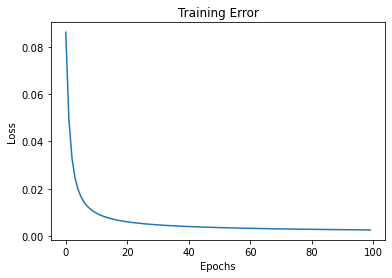

In [17]:
fig, ax = plt.subplots()
ax.plot(np.array(mlp_network.error_memory))
ax.set_title('Training Error')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()

#### Get the exemplary Accuracy:

In [18]:
y_pred_mlp = mlp_network.predict(X_test_zip)

In [19]:
mlp_network.accuracy(y_test_zip, y_pred_mlp)

0.9807383627608347

In [20]:
np.unique(y_pred_mlp, return_counts=True)

(array([0, 1]), array([365, 258], dtype=int64))

In [21]:
np.unique(y_test_zip, return_counts=True)

(array([0., 1.]), array([359, 264], dtype=int64))

#### Get a mean accuracy over multiple runs

In [22]:
acc_list_mlp = []
n_runs = 10
for i in range(n_runs):
    mlp_network = MLP(depth=3, layer_width=[X_train_zip.shape[1], 100, 10, 1], iterations=100, no_batches=100)
    mlp_network.train(X_train_zip, y_train_zip)
    y_pred_loop = mlp_network.predict(X_test_zip)
    acc_list_mlp.append(mlp_network.accuracy(y_test_zip, y_pred_loop))
print("Mean Acc over", n_runs, "runs, with random weights is:", np.mean(acc_list_mlp))

Mean Acc over 10 runs, with random weights is: 0.9853932584269662


## (a.i) Optimize width (the number of neurons in a hidden layer; it is usually the same for all of them) and depth of the network. Try to find a setting that trains in a reasonable time.

In [27]:
def cross_validation(X_train, y_train, y_test, depths, widths, nr_folds = 5):
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    fold_indices_list = np.array_split(indices, nr_folds)
    
    cv_acc_mlp = []
    cv_loss_mlp = []
    for fold_counter, val_indices in enumerate(fold_indices_list):
        print("Fold:",fold_counter)
        X_val = X_train[val_indices]
        y_val = y_train[val_indices]
        X_training = np.delete(X_train, val_indices, 0)
        y_training = np.delete(y_train, val_indices, 0)
        depth_accs = []
        depth_loss = []
        for depth in depths:
            width_accs = []
            width_loss = []
            for width in widths:
                width_list = [X_train_zip.shape[1]] + [width] * (depth-1) + [1]
                cross_val_mlp = MLP(depth=depth, layer_width=width_list, iterations=100, no_batches=100)
                cross_val_mlp.train(X_training, y_training)
                y_pred_cv = cross_val_mlp.predict(X_val)
                width_accs.append(cross_val_mlp.accuracy(y_val, y_pred_cv))
                width_loss.append(cross_val_mlp.error_memory)
            depth_accs.append(width_accs)
            depth_loss.append(width_loss)
        cv_acc_mlp.append(depth_accs)
        cv_loss_mlp.append(depth_loss)
    return (np.mean(np.array(cv_acc_mlp), axis=0), np.mean(np.array(cv_loss_mlp), axis=0))

In [28]:
cv_depths = [2, 3, 4]
cv_widths = [15, 20, 25, 30]
cv_accuracies, cv_losses = cross_validation(X_train_zip, y_train_zip, y_test_zip, cv_depths, cv_widths, nr_folds = 5)

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [29]:
i_max,j_max = np.unravel_index(cv_accuracies.argmax(), cv_accuracies.shape)
print("Best depth:", cv_depths[i_max])
print("Best width:", cv_widths[j_max])
print("CV Accuracy there:", np.max(cv_accuracies))

Best depth: 2
Best width: 25
CV Accuracy there: 0.9972696210395527


### Result:
The Optimized width was: 25<br>
The Optimized depth was: 2

## (a.ii) Plot the loss.
We plot the loss for different widths as a plot of loss vs iterations, with a new plot for each depth.

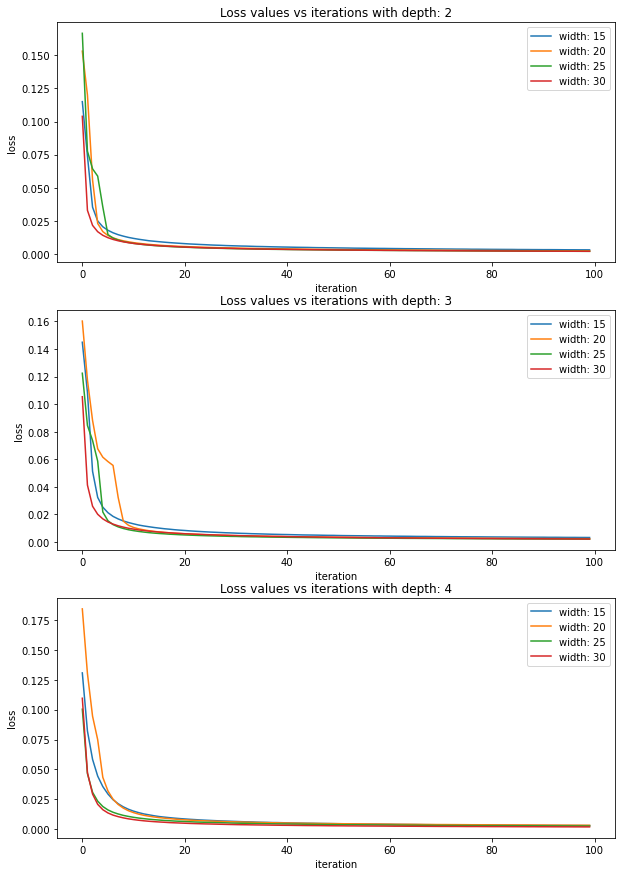

In [30]:
iterations = np.arange(len(cv_losses[0,0]))
fig, axs = plt.subplots(len(cv_depths), 1, figsize=(10,15))
for i, depth in enumerate(cv_depths):
    for j, width in enumerate(cv_widths):
        axs[i].plot(iterations, cv_losses[i,j], label="width: {}".format(width))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('loss')
    axs[i].set_title('Loss values vs iterations with depth: {}'.format(depth))
    axs[i].legend()
plt.show()

## (b) Show some digits that are classified incorrectly.

### Implement the optimized model from the crossvalidation:

In [32]:
mlp_network_refined = MLP(depth=2, layer_width=[X_train_zip.shape[1], 25, 1], iterations=100, no_batches=100)

for weight_v in mlp_network_refined.network_weights:
    print(weight_v.shape)

mlp_network_refined.train(X_train_zip, y_train_zip)

y_pred_refined = mlp_network_refined.predict(X_test_zip)

mlp_network_refined.accuracy(y_test_zip, y_pred_refined)

(257, 25)
(26, 1)


0.9871589085072231

### Show the missclassified numbers:

In [33]:
def show_few_numbers(Xi):
    fig = plt.figure(figsize=(10, 6))
    i = 1
    for X in Xi:
        ax = plt.subplot(len(Xi)//10 + 1, 10, i)
        plt.imshow(1-X.reshape((16, 16)), cmap='gray')
        plt.axis('off')
        i += 1

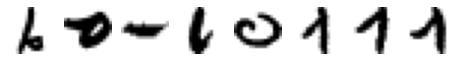

In [34]:
show_few_numbers(X_test_zip[np.where(y_test_zip != y_pred_refined)])

## (c) Plot your first weight layer as a grayscale image.

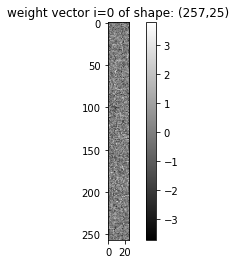

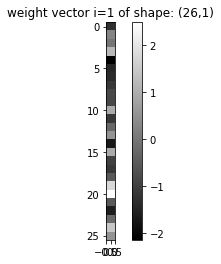

In [35]:
for i, weight_vector_img in enumerate(mlp_network_refined.network_weights):
    plt.imshow(weight_vector_img, cmap='gray')
    plt.title("weight vector i={} of shape: ({},{})".format(i, weight_vector_img.shape[0], weight_vector_img.shape[1]))
    plt.colorbar()
    plt.show()

### Show the distibution of the Network weights:

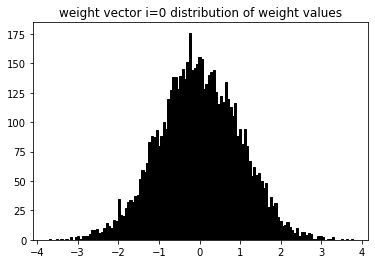

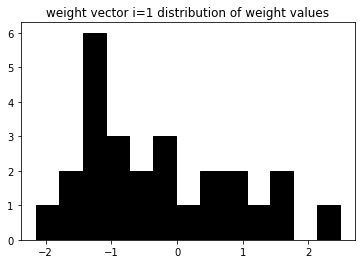

In [40]:
for i, weight_vector_img in enumerate(mlp_network_refined.network_weights):
    plt.hist(weight_vector_img.ravel(), bins=(weight_vector_img.shape[0]//2), fc='k', ec='k')
    plt.title("weight vector i={} distribution of weight values".format(i))
    plt.show()